## 1. Сделайте краткий обзор какой-нибудь научной работы посвященной тому или иному алгоритму для object detection, который не рассматривался на уроке. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике?

### Ответ:
- __Histogram of Oriented Gradients (HOG)__

Иммет в себе уже запланированные ориентации градиента которые могут встречаться в каждом сегменте матрицы изображения

++ Прост для понимания человеком, так как восоздает образ улавлиемого объекта

- __Region-based Fully Convolutional Network (R-FCN)__

Полностью сверточный алгоритм

- __Spatial Pyramid Pooling (SPP-net)__

Сочитается с алгоритмами CNN

++ Этот алгоритм, может генерировать представления фиксированного размера, независимо от размера изображения.<br>
++ Можно вычислить характеристики изображений всего один раз, а затем случайным образом объединять части ихображений, для создания представлений фиксированного размера, что бы обучать детекторы. <br> 
++ Этот метод позволяет избежать повторного вычисления сверточных функций.<br>
++ Устойчив к деформациям объектов

Ссылки: 
- https://analyticsindiamag.com/top-8-algorithms-for-object-detection/
- https://arxiv.org/abs/1406.4729
- https://arxiv.org/pdf/1406.4729.pdf

# 2. Запустите детектор (SSD или Faster R-CNN) из детекторы_7.ipynb для своего изображения (любое фотореалистичное) и постройте 3 объекта, 10 объектов, 100 объектов детектора.

In [1]:
# подключение диска
from google.colab import drive
drive.mount('/content/drive')

# сбор картинок
import os
PATH_TO_IMGS = '/content/drive/MyDrive/Introduction to neural networks/data_sets/images/'
img_list = os.listdir(PATH_TO_IMGS)

# основные библиотеки
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time

import tensorflow_hub as hub
import tensorflow as tf

from PIL import Image, ImageFont, ImageColor, ImageDraw

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


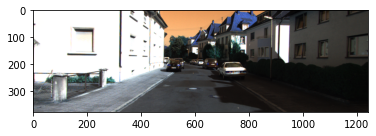

In [2]:
# просмотр пример картинки
img = cv2.imread(PATH_TO_IMGS + img_list[0])

plt.imshow(img)
plt.show()

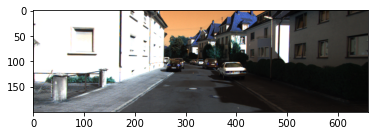

In [3]:
# изменение размера
newH = 200
newW = int(img.shape[1] * newH / img.shape[0])

img = cv2.resize(img, (newW, newH))

plt.imshow(img)
plt.show()

In [4]:
module_handle = {"ssd": "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", 
                 "faster_rcnn": "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"}

detector = hub.load(module_handle['ssd']).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [5]:
def load_img(path):
  # path - маршрут и имя файла для обработки

  img = tf.io.read_file(path)
  img = tf.image.decode_png(img, channels=3)
  # вернет картинку как тензор
  return img

# выводит картинку
def display_image(image):
  fig = plt.figure(figsize=(12, 9))
  plt.imshow(image)

In [6]:
def draw_bounding_box_on_image(image,
                               ymin, xmin,
                               ymax, xmax,
                               color, font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

# Рисуем все рамки
# max_boxes - максимальное число объектов для отображения, min_score=0.01 - минимакльная точность их детекции
# можно менять

In [7]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=3, min_score=0.01):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin, xmin,
          ymax, xmax,
          color, font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [8]:
def run_detector(detector, path, max_boxes):
  '''
  1) вызывает детектор с картинкой
  2) выводит результат на картинке

  detector - объект детектор,
  path - маршрут и имя файла для обработки
  '''
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()
  result = {key: value.numpy() for key, value in result.items()} 

  # max_boxes - максимальное число объектов для отображения, min_score=0.0 - минимакльная точность их детекции 
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], max_boxes=max_boxes)

  display_image(image_with_boxes)

  return result

In [9]:
import os, fnmatch
pattern = '*.png'
list_name = []
for entry in img_list:
    if fnmatch.fnmatch(entry, pattern):
            list_name.append(np.array(PATH_TO_IMGS + entry))
list_name[0]

array('/content/drive/MyDrive/Introduction to neural networks/data_sets/images/00_002200.png',
      dtype='<U85')

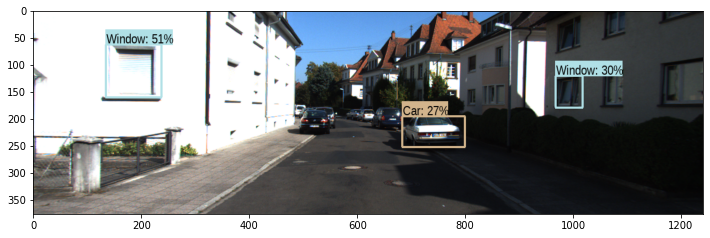

In [10]:
result = run_detector(detector, list_name[0], max_boxes=3)

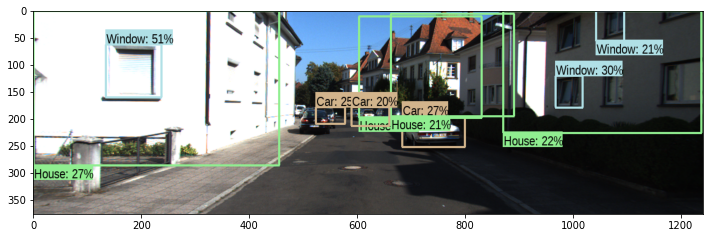

In [11]:
result = run_detector(detector, list_name[0], max_boxes=10)

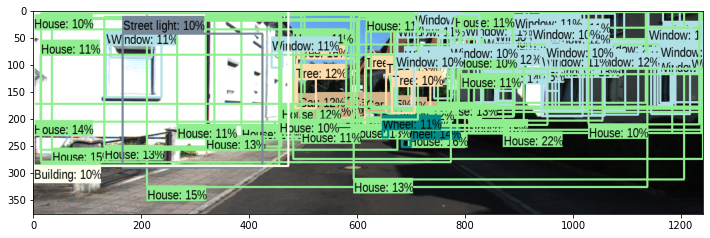

In [12]:
result = run_detector(detector, list_name[0], max_boxes=100)

### Вывод:
При слишком большом числе искомых объектов модель начинает объединять несколько объектов в один объект.

## 3. Ссылка на репозиторий с полным кодом для обучения ssd нейросети - https://github.com/sergeyveneckiy/ssd-tensorflow. Попробуйте улучшить точность ее работы и напишите отчет, что вы пробовали изменить в ее параметрах и как это отражалось на процессе обучения нейронной сети. Обратите внимание! Мин. сист. требования для запуска данного проекта - это минимум 8 Gb ОЗУ. Если у вас недостаточно мощности компьютера, то вы можете просто изучить содержимое исходного кода и датасета данного проекта.